In [200]:
import pandas as pd

In [201]:
df = pd.read_csv('race_info.csv', low_memory=False)
df = df.drop(columns = ["Unnamed: 0"])
df['wgDf']= df['wgDf'].fillna(0)
df = df.drop(columns = ['rankRise','meet','ordBigo','index'])
columns_to_convert = ['humidity', 'buga1', 'buga2', 'buga3', 'chaksun1', 'chaksun2', 'chaksun3', 'chaksun4', 'chaksun5',
                     'rcTime', 'seG1fAccTime', 'seG3fAccTime', 'seS1fAccTime', 'se_1cAccTime', 'se_2cAccTime', 
                     'se_3cAccTime', 'se_4cAccTime', 'sjG1fOrd', 'sjG3fOrd', 'sjS1fOrd', 'sj_1cOrd', 'sj_2cOrd', 
                     'sj_3cOrd', 'sj_4cOrd', 'age', 'winOdds', 'ord', 'wgHr', 'wgDf', 'chulNo', 'hrNo', 'plcOdds', 
                     'rating', 'wgBudam', 'wgJk']

df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')
df_dtypes = df.dtypes.to_dict()


In [202]:
#Convert dates to datetime
df['rcDate'] = pd.to_datetime(df['rcDate'])
df = df.sort_values(["rcDate", "rcNo"])
print(min(df['rcDate']))
print(max(df['rcDate']))

2019-01-05 00:00:00
2024-04-28 00:00:00


# Split Train / Validation

Split based on datetime.

In [203]:
train_df = df[df['rcDate'] < pd.to_datetime("2023-01-01")]
valid_df = df[df['rcDate'] >= pd.to_datetime("2023-01-01")]

train_df.to_csv("race_train_2023_01_01.csv", index=False)
valid_df.to_csv("race_valid_2023_01_01.csv", index=False)

In [204]:
train_df = pd.read_csv('race_train_2023_01_01.csv', dtype=df_dtypes)
valid_df = pd.read_csv('race_valid_2023_01_01.csv', dtype=df_dtypes)

In [205]:
train_df.columns

Index(['birthday', 'ageCond', 'age', 'winOdds', 'sj_3cOrd', 'ord', 'wgHr',
       'track', 'wgDf', 'humidity', 'budam', 'buga1', 'buga2', 'buga3',
       'chaksun1', 'chaksun2', 'chaksun3', 'chaksun4', 'chaksun5', 'chulNo',
       'diffUnit', 'hrName', 'hrNo', 'hrTool', 'ilsu', 'jkName', 'jkNo',
       'name', 'owName', 'owNo', 'plcOdds', 'prizeCond', 'rank', 'rating',
       'rcDate', 'rcDay', 'rcDist', 'rcName', 'rcNo', 'rcTime', 'seG1fAccTime',
       'seG3fAccTime', 'seS1fAccTime', 'se_1cAccTime', 'se_2cAccTime',
       'se_3cAccTime', 'se_4cAccTime', 'sex', 'sjG1fOrd', 'sjG3fOrd',
       'sjS1fOrd', 'sj_1cOrd', 'sj_2cOrd', 'sj_4cOrd', 'trName', 'trNo',
       'weather', 'wgBudam', 'wgBudamBigo', 'wgJk'],
      dtype='object')

In [206]:
#Imports

import matplotlib.pyplot as plt

In [207]:
print("train_df is nan num: ", train_df.isna().sum().sum())
print("valid_df is nan num: ", valid_df.isna().sum().sum())

train_df is nan num:  0
valid_df is nan num:  0


int64


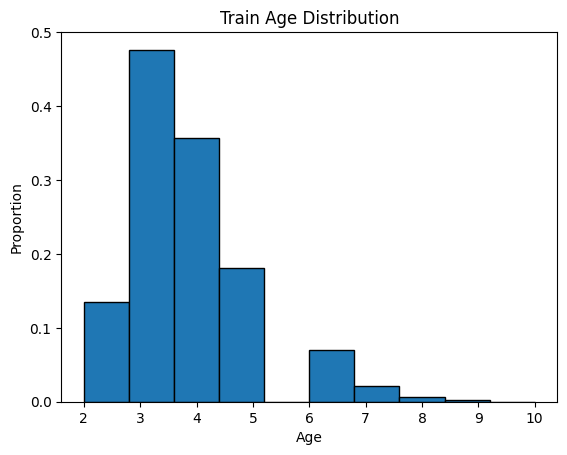

count    40354.000000
mean         3.737820
std          1.178767
min          2.000000
25%          3.000000
50%          4.000000
75%          4.000000
max         10.000000
Name: age, dtype: float64


In [208]:
print(train_df.age.dtype)

# Plot histogram for a given column, e.g., 'value'
plt.hist(train_df['age'], edgecolor='black', density=True)

# Add titles and labels
plt.title('Train Age Distribution')
plt.xlabel('Age')
plt.ylabel('Proportion')

# Show the plot
plt.show()
print(train_df.age.describe())


int64


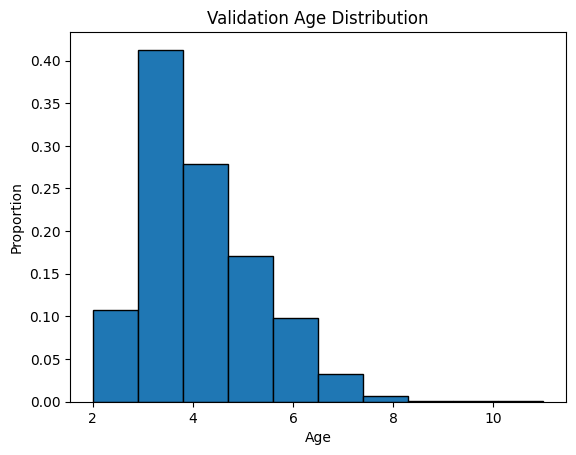

count    14651.000000
mean         3.891543
std          1.303779
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max         11.000000
Name: age, dtype: float64


In [209]:
print(valid_df.age.dtype)

# Plot histogram for a given column, e.g., 'value'
plt.hist(valid_df['age'], edgecolor='black', density=True)

# Add titles and labels
plt.title('Validation Age Distribution')
plt.xlabel('Age')
plt.ylabel('Proportion')

# Show the plot
plt.show()
print(valid_df.age.describe())

# Columns to ignore


float64


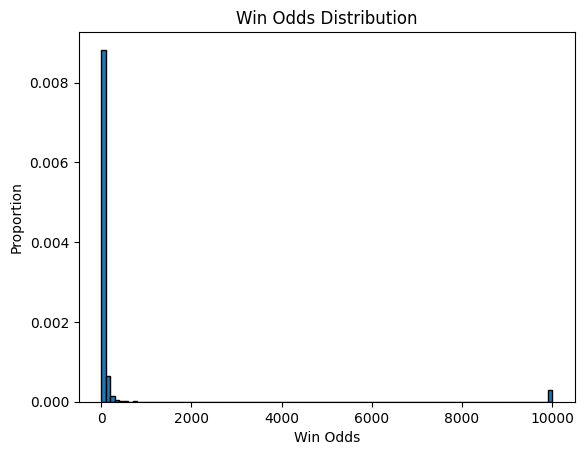

In [210]:
print(df.winOdds.dtype)
# Plot histogram for a given column, e.g., 'value'
plt.hist(df['winOdds'], bins=100, edgecolor='black', density=True)

# Add titles and labels
plt.title('Win Odds Distribution')
plt.xlabel('Win Odds')
plt.ylabel('Proportion')

# Show the plot
plt.show()

Plot above shows outlier near 500 region. We consider this as an outlier.

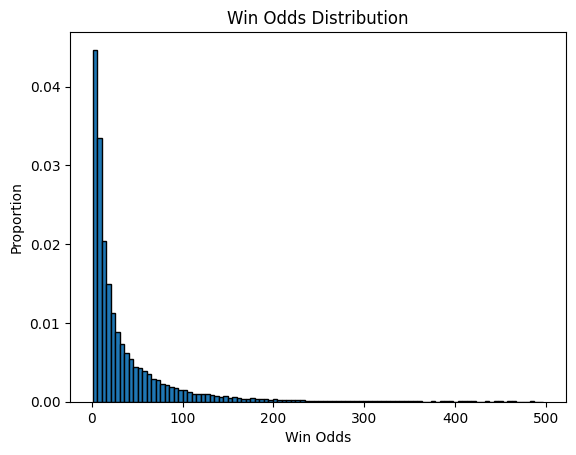

In [211]:
df = df[df['winOdds'] <= 500]
# Plot histogram for a given column, e.g., 'value'
plt.hist(df['winOdds'], bins=100, edgecolor='black', density=True)

# Add titles and labels
plt.title('Win Odds Distribution')
plt.xlabel('Win Odds')
plt.ylabel('Proportion')

# Show the plot
plt.show()

Win Odds is for every horse. 

Instead of feeding the raw value as a feature, we can plot a win odds distribution and feed the p-value of the cdf of the exponential distribution.

Reason
- Raw value has very large scale. The absolute numbers may not mean anything. To help ML model converge faster, we feed meaningful, range bounded value. p-value has range [0.0, 1.0].

In [212]:
from scipy.stats import expon, norm
import numpy as np

class Preprocessing:
    def __init__(self):
        self.win_odd_loc = 0.0
        self.win_odd_scale = 0.0

        self.plc_odd_loc = 0.0
        self.plc_odd_scale = 0.0

        self.wgDf_mu = 0.0
        self.wgDf_scale = 0.0
    
    def fit(self, df):
        params = expon.fit(df["winOdds"])
        self.win_odd_loc, self.win_odd_scale = params

        params = expon.fit(df["plcOdds"])
        self.plc_odd_loc, self.plc_odd_scale = params

        log_weight_diff = np.log(df["wgHr"]) - np.log(df["wgHr"] + df["wgDf"])

        self.wgDf_mu = np.mean(log_weight_diff)
        self.wgDf_scale = np.std(log_weight_diff, ddof=1)

    def forward(self, df):
        df['winOdds'] = 1-expon.cdf(df['winOdds'], loc=self.win_odd_loc, scale=self.win_odd_scale)
        df['plcOdds'] = 1-expon.cdf(df['plcOdds'], loc=self.plc_odd_loc, scale=self.plc_odd_scale)
        log_weight_diff = np.log(df["wgHr"]) - np.log(df["wgHr"] + df["wgDf"])
        df['wgDf'] = (log_weight_diff - self.wgDf_mu) / self.wgDf_scale
        return df

preprocessing = Preprocessing()


In [213]:
preprocessing.fit(train_df)
train_df = preprocessing.forward(train_df)
valid_df = preprocessing.forward(valid_df)

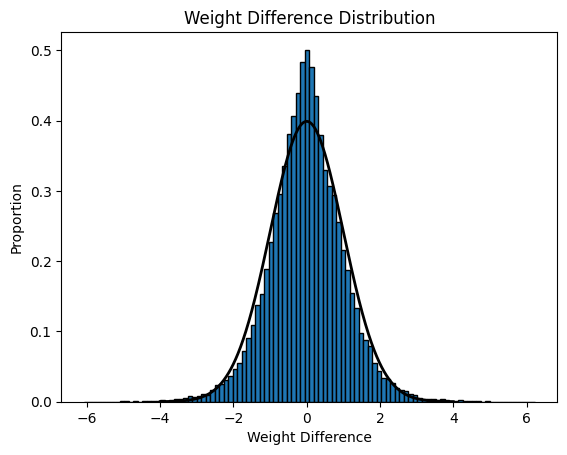

In [214]:
plt.hist(train_df['wgDf'], bins=100, edgecolor='black', density=True)

# Create a range of values for plotting the PDF
xmin, xmax = plt.xlim()
x = np.linspace(-4, 4, 1000)

# Plot the fitted normal distribution
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)

# Add titles and labels
plt.title('Weight Difference Distribution')
plt.xlabel('Weight Difference')
plt.ylabel('Proportion')

# Show the plot
plt.show()

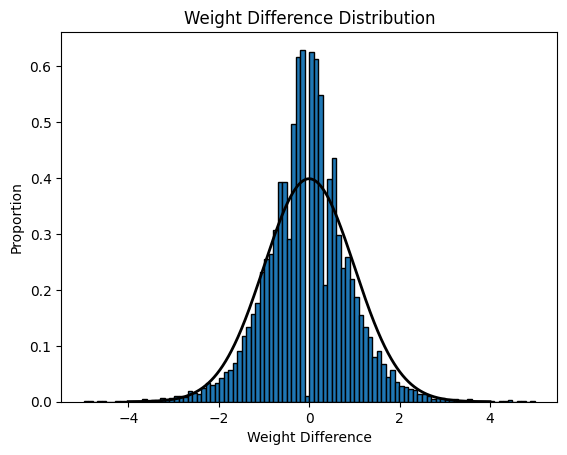

In [215]:
plt.hist(valid_df['wgDf'], bins=100, edgecolor='black', density=True)
# Create a range of values for plotting the PDF
xmin, xmax = plt.xlim()
x = np.linspace(-4, 4, 1000)

# Plot the fitted normal distribution
p = norm.pdf(x, 0, 1)
plt.plot(x, p, 'k', linewidth=2)

# Add titles and labels
plt.title('Weight Difference Distribution')
plt.xlabel('Weight Difference')
plt.ylabel('Proportion')

# Show the plot
plt.show()

In [216]:
train_df["diffUnit"].unique()
# make a token dictionary, and convert to token_id

array(['-', '목', '4', '1¼', '코', '머리', '½', '2', '5', '1', '1¾', '¾', '3',
       '1½', '37', '2½', '10', '6', '7', '17', '13', '20', '44', '동순위',
       '18', '9', '8', '19', '12', '83', '36', '16', '11', '35', '14',
       '21', '2+½', '23', '26', '25', '32', '15', '1¼+1', '착변', '코+3',
       '34', '500', '57', '2½+1', '22', '28', '43', '42', '79', '72',
       '45', '33', '49', '62', '59', '27', '½+코', '48', '70', '41', '60',
       '1+½', '46', '30', '31', '63', '65', '52', '39', '47', '38', '50',
       '40', '24', '착변+코', '71', '92', '66', '코+¾', '29', '86', '285',
       '7+¾', '88', '85', '77', '101', '¾+3', '64', '58', '73', '착변+½',
       '56', '80', '179', '81', '67', '89', '177', '착변+머리', '69', '96',
       '122', '55', '코+코', '코+1½', '19+1¾'], dtype=object)

In [226]:
# train_df["hrTool"].unique()
# Tokenize each string, make this into a sequence, get unique tokens, and convert to token_id sequence
import re

# Function to split the string
def split_word_suffix(word):
    match = re.match(r"([\uAC00-\uD7AFa-zA-Z]+)([+-])", word)
    if match:
        return match.groups()
    else:
        return (word, '')

def tokenize_hr_tool(hr_tool):
    hr_tools = hr_tool.split(",")
    for i in range(len(hr_tools)):
        hr_tool_clean = hr_tools[i].replace(" ", "")
        hr_tool_clean = split_word_suffix(hr_tool_clean)

tmp = train_df["hrTool"].apply(tokenize_hr_tool)
for hrTool in train_df["hrTool"]:
    print(hrTool)

# tokenize --> list of token strings --> unique --> tokens --> dictionary map (key: token, value: token_id (integer)) --> convert to token_id sequence
# [3,6,21,4] --> string --> "3,6,21,4" --> .split(",")


('망사눈', '')
('망사눈', '')
('승인재갈', '')
('-', '')
('망사', '')
('망사눈', '')
('-', '')
('승인재갈', '')
('눈가면', '')
('눈가면', '')
('망사', '')
('승인재갈', '+')
('망사눈', '')
('승인재갈', '')
('망사눈', '+')
('망사', '-')
('망사눈', '')
('망사', '+')
('눈가면', '-')
('망사', '')
('망사눈', '')
('망사눈', '')
('눈가면', '')
('망사눈', '')
('승인재갈', '')
('혀끈', '')
('망사', '')
('망사눈', '')
('승인재갈', '+')
('승인재갈', '')
('눈가면', '')
('망사눈', '')
('망사', '')
('승인재갈', '')
('눈가면', '')
('승인재갈', '')
('-', '')
('망사눈', '')
('망사눈', '')
('망사눈', '')
('망사', '')
('망사', '')
('승인재갈', '')
('망사눈', '')
('승인재갈', '')
('자극판', '+')
('눈가면', '+')
('망사', '-')
('승인재갈', '-')
('망사눈', '')
('망사눈', '')
('승인재갈', '')
('-', '')
('망사', '+')
('승인재갈', '')
('혀끈', '+')
('-', '')
('망사', '+')
('망사눈', '')
('-', '')
('-', '')
('망사눈', '+')
('승인재갈', '')
('눈가면', '-')
('망사눈', '')
('승인재갈', '')
('승인재갈', '')
('-', '')
('-', '')
('-', '')
('-', '')
('망사눈', '-')
('망사눈', '+')
('승인재갈', '+')
('망사', '')
('승인재갈', '')
('-', '')
('망사눈', '')
('승인재갈', '')
('망사눈', '')
('승인재갈', '')
('망사눈', '')
('승인재갈', '-')
('

float64


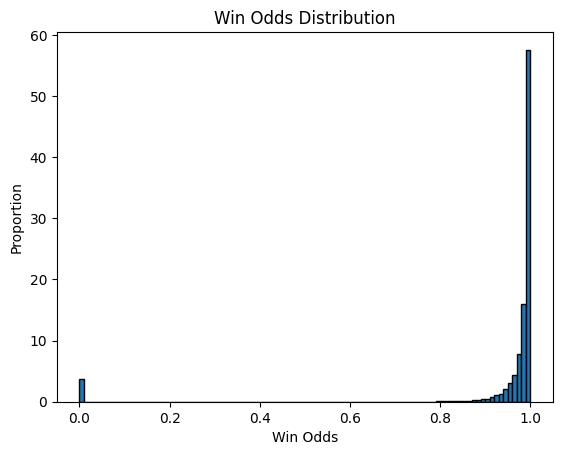

In [218]:
print(train_df.plcOdds.dtype)
# Plot histogram for a given column, e.g., 'value'
plt.hist(train_df['plcOdds'], bins=100, edgecolor='black', density=True)

# Add titles and labels
plt.title('Win Odds Distribution')
plt.xlabel('Win Odds')
plt.ylabel('Proportion')

# Show the plot
plt.show()

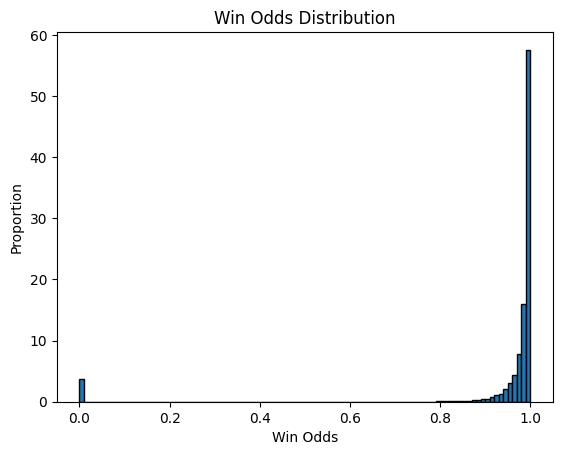

In [219]:
train_df = train_df[train_df['plcOdds'] <= 500]
# Plot histogram for a given column, e.g., 'value'
plt.hist(train_df['plcOdds'], bins=100, edgecolor='black', density=True)

# Add titles and labels
plt.title('Win Odds Distribution')
plt.xlabel('Win Odds')
plt.ylabel('Proportion')

# Show the plot
plt.show()

int64


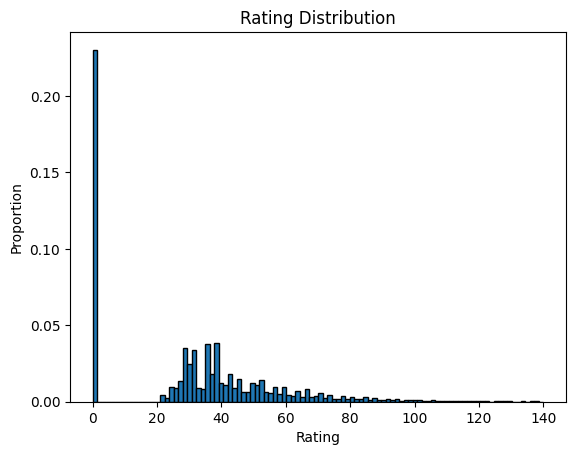

In [220]:
print(train_df.rating.dtype)
# Plot histogram for a given column, e.g., 'value'
plt.hist(train_df['rating'], bins=100, edgecolor='black', density=True)

# Add titles and labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Proportion')

# Show the plot
plt.show()

WTF is this?
--> Sean is going to objectively explain.

In [221]:
train_df["rank"].unique()
# 

array(['국6등급', '혼4등급', '국5등급', '국4등급', '2등급', '혼3등급', '국3등급', '1등급',
       '국OPEN', '혼OPEN'], dtype=object)

In [222]:
train_df["sex"].unique()

array(['암', '수', '거'], dtype=object)